In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split    # split the data into train and test
from skimage.measure import block_reduce                # downsample the image
from sklearn import preprocessing as pp                 # normalize the data


letter_params = {
    "fontsize": 10,
    "verticalalignment": "top",
    "horizontalalignment": "left",
    "bbox": {"edgecolor": "k", "linewidth": 1, "facecolor": "w",}
}

In [4]:
path = 'newnpz/'
path = 'npz100_plus/'
path = 'npz100/'
files = sorted(os.listdir(path))

images = []
labels = []
for file in files:
    data = np.load(os.path.join(path, file))
    images.append(data['raw'])
    labels.append(data['label'])

images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.float32)

labels = images - labels

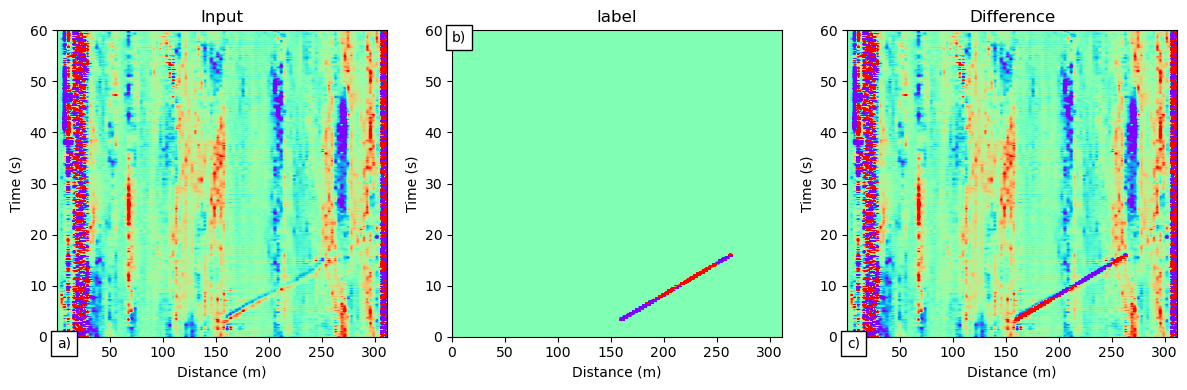

In [7]:
i = 10
scale = 0.005
dt, dx = 0.001, 3.0
nt, nx = images[i].shape
x = nx*dx
t = nt*dt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
ax1.imshow(images[i], aspect = 'auto', cmap='rainbow', vmin=-scale, vmax=scale, extent=[0, x, 0, t])
ax1.set_title('Input'), ax1.set_ylabel('Time (s)'), ax1.set_xlabel('Distance (m)')
ax1.text(x=0, y=60, s="a)", **letter_params)
ax2.imshow(labels[i], aspect = 'auto', cmap='rainbow', vmin=-scale, vmax=scale, extent=[0, x, 0, t])
ax2.set_title('label'), ax2.set_ylabel('Time (s)'), ax2.set_xlabel('Distance (m)')
ax2.text(x=0, y=60, s="b)", **letter_params)
ax3.imshow(images[i]-labels[i], aspect = 'auto', cmap='rainbow', vmin=-scale, vmax=scale, extent=[0, x, 0, t])
ax3.set_title('Difference'), ax3.set_ylabel('Time (s)'), ax3.set_xlabel('Distance (m)')
ax3.text(x=0, y=60, s="c)", **letter_params)
plt.tight_layout()

In [8]:
images = images[..., 20:100]
labels = labels[..., 20:100]

# downsample the data
images = block_reduce(images, block_size=(1, 100, 1), func=np.mean)
labels = block_reduce(labels, block_size=(1, 100, 1), func=np.mean)

# normalize the data
for i in range(len(images)):
    images[i] = images[i] / np.std(images[i])
    labels[i] = labels[i] / np.std(labels[i])


X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.01, random_state=155)

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

X_train = tf.expand_dims(X_train, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)
y_train = tf.expand_dims(y_train, axis=-1)
y_test = tf.expand_dims(y_test, axis=-1)

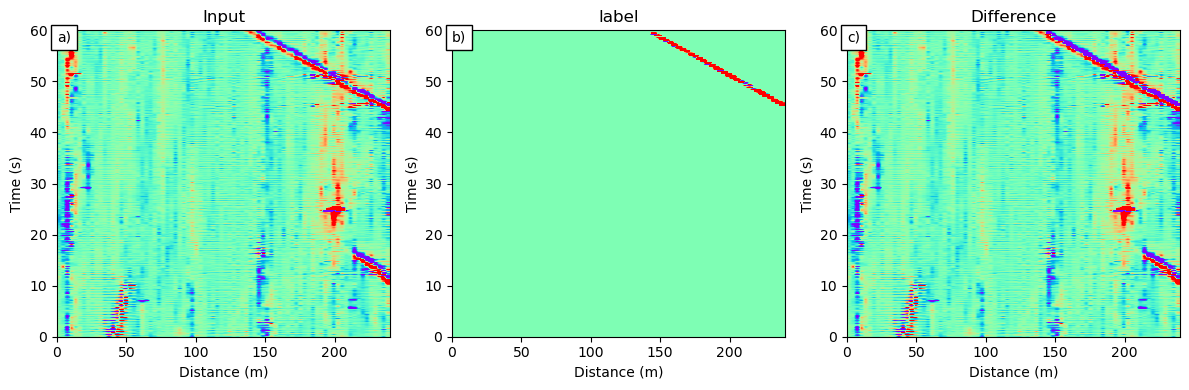

In [9]:
import matplotlib.pyplot as plt

i = 3
scale = 0.5
dt, dx = 0.1, 3.0
nt, nx, _ = X_train[i].shape
x = nx*dx
t = nt*dt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
ax1.imshow(X_train[i], aspect = 'auto', cmap='rainbow', vmin=-scale, vmax=scale, extent=[0, x, 0, t])
ax1.set_title('Input'), ax1.set_ylabel('Time (s)'), ax1.set_xlabel('Distance (m)')
ax1.text(x=0, y=60, s="a)", **letter_params)
ax2.imshow(y_train[i], aspect = 'auto', cmap='rainbow', vmin=-scale, vmax=scale, extent=[0, x, 0, t])
ax2.set_title('label'), ax2.set_ylabel('Time (s)'), ax2.set_xlabel('Distance (m)')
ax2.text(x=0, y=60, s="b)", **letter_params)
ax3.imshow(images[i]-labels[i], aspect = 'auto', cmap='rainbow', vmin=-scale, vmax=scale, extent=[0, x, 0, t])
ax3.set_title('Difference'), ax3.set_ylabel('Time (s)'), ax3.set_xlabel('Distance (m)')
ax3.text(x=0, y=60, s="c)", **letter_params)
plt.tight_layout()

In [ ]:

# batch_size = 16
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# train_dataset = train_dataset.shuffle(10000).batch(batch_size)

In [16]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D

class MyModel(Model):
    def __init__(self, input_shape):
        super(MyModel, self).__init__()
        self.conv11 = Conv2D(32, 3, activation='relu', padding='same')
        self.conv12 = Conv2D(32, 3, activation='relu', padding='same')

        self.maxpool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv21 = Conv2D(64, 3, activation='relu', padding='same')
        self.conv22 = Conv2D(64, 3, activation='relu', padding='same')

        self.maxpool2 = tf.keras.layers.MaxPooling2D((2, 2)) 
        self.conv31 = Conv2D(128, 3, activation='relu', padding='same')
        self.conv32 = Conv2D(128, 3, activation='relu', padding='same')
        self.conv33 = Conv2D(128, 3, activation='relu', padding='same')

        self.up2 = tf.keras.layers.UpSampling2D((2, 2))
        self.concat2 = tf.keras.layers.Concatenate(axis=3)
        self.convup21 = Conv2D(64, 3, activation='relu', padding='same')
        self.convup22 = Conv2D(64, 3, activation='relu', padding='same')

        self.up1 = tf.keras.layers.UpSampling2D((2, 2))
        self.concat1 = tf.keras.layers.Concatenate(axis=3)
        self.convup11 = Conv2D(32, 3, activation='relu', padding='same')
        self.convup12 = Conv2D(32, 3, activation='relu', padding='same')

        self.conva = Conv2D(3, 1, activation='relu', padding='same')
        self.conva1 = Conv2D(1, 1, activation='relu', padding='same')


    def call(self, x):
        x = self.conv11(x)
        x = self.conv12(x)
        x1 = x      # 28x28x32

        x = self.maxpool1(x) # 14x14x32
        x = self.conv21(x)
        x = self.conv22(x)   # 14x14x64
        x2 = x

        x = self.maxpool2(x) # 7x7x64
        x = self.conv31(x)
        x = self.conv32(x)
        x = self.conv33(x)   # 7x7x128

        up2 = self.up2(x)    # 14x14x64
        x = self.concat2([x2, up2]) 
        x = self.convup21(x)   
        x = self.convup22(x)  

        up1 = self.up1(x)    # 28x28x32
        x = self.concat1([x1, up1])
        x = self.convup11(x)
        x = self.convup12(x) 

        x = self.conva(x)
        x = self.conva1(x)
        
        return x

# Create an instance of the model
inputs = tf.keras.Input(shape=X_train.shape[1:])
model = tf.keras.Model(inputs=inputs, outputs=MyModel(inputs).call(inputs))

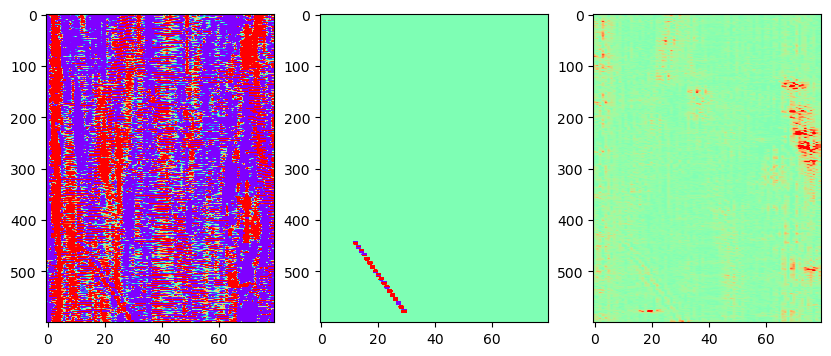

In [20]:
import matplotlib.pyplot as plt

i = 7
scale = 0.1
yyy = model(X_train[i:i+1])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 4))
ax1.imshow(X_train[i], aspect = 'auto', vmin=-scale, vmax=scale, cmap='rainbow')
ax2.imshow(y_train[i], aspect = 'auto', vmin=-scale, vmax=scale, cmap='rainbow')
ax3.imshow(yyy[0], aspect = 'auto', cmap='rainbow', vmin=-scale, vmax=scale)

In [21]:
optermizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()

model.compile(optimizer=optermizer, 
              loss=loss)

# 创建ModelCheckpoint回调函数，用于保存模型
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint.h5',  # 模型保存路径
    save_best_only=True,  # 只保存在验证集上表现最好的模型
    monitor='val_loss',  # 监控的指标，可以是'val_loss'或其他指标
    mode='max',  # 监控指标的模式，'max'表示越大越好，'min'表示越小越好
    verbose=1  # 显示保存信息
)

# 训练模型
#model.fit(train_dataset, epochs=1000, callbacks=[checkpoint_callback])
#model.fit(images, labels, epochs=100, callbacks=[checkpoint_callback])
model.fit(X_train, y_train, epochs=100, callbacks=[checkpoint_callback])

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.0005
Epoch 2/100
1/1 [==============================] - 0s 60ms/step - loss: 0.9994
Epoch 3/100
1/1 [==============================] - 0s 55ms/step - loss: 0.9982
Epoch 4/100
1/1 [==============================] - 0s 57ms/step - loss: 0.9968
Epoch 5/100
1/1 [==============================] - 0s 64ms/step - loss: 0.9961
Epoch 6/100
1/1 [==============================] - 0s 58ms/step - loss: 0.9939
Epoch 7/100
1/1 [==============================] - 0s 65ms/step - loss: 0.9910
Epoch 8/100
1/1 [==============================] - 0s 64ms/step - loss: 0.9861
Epoch 9/100
1/1 [==============================] - 0s 45ms/step - loss: 0.9912
Epoch 10/100
1/1 [==============================] - 0s 49ms/step - loss: 0.9895
Epoch 11/100
1/1 [==============================] - 0s 43ms/step - loss: 0.9943
Epoch 12/100
1/1 [==============================] - 0s 52ms/step - loss: 0.9978
Epoch 13/100
1/1 [==============================] -

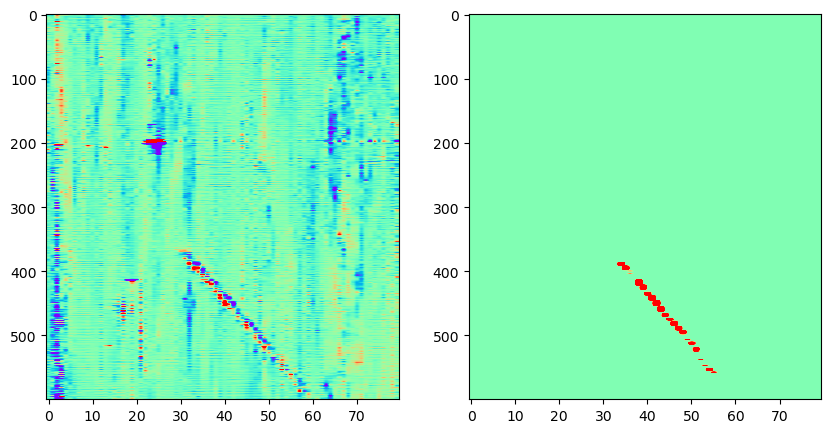

In [22]:
i = 1
scale = 0.5
yyy = model(images[i:i+1])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(images[i], aspect='auto', cmap='rainbow', vmin=-scale, vmax=scale)
ax2.imshow(yyy[0], aspect='auto', cmap='rainbow', vmin=-scale, vmax=scale)


In [ ]:
yyy[0].numpy().max()

In [ ]:
x, t

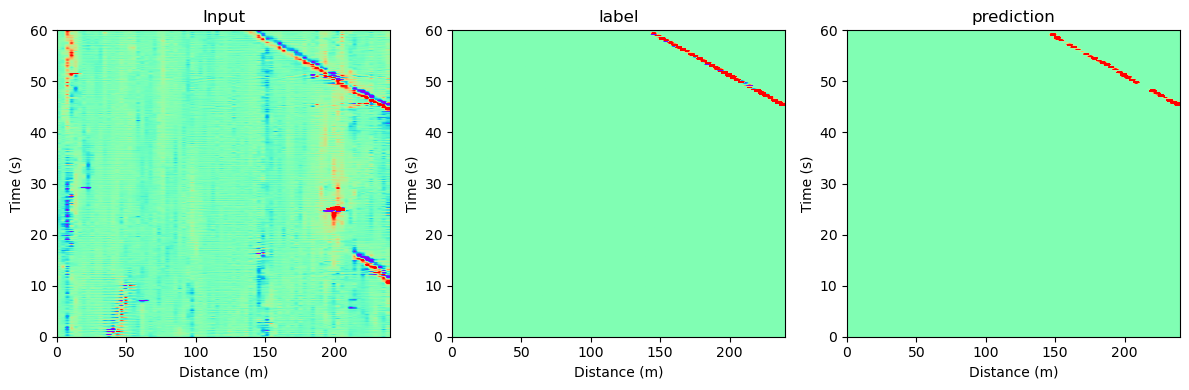

In [35]:
import matplotlib.pyplot as plt

i = 3
scale = 1.0
yyy = model(X_train[i:i+1])
dt, dx = 0.1, 3.0
nt, nx = images[i].shape
x = nx*dx
t = nt*dt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
ax1.imshow(X_train[i], aspect = 'auto', cmap='rainbow', vmin=-scale, vmax=scale, extent=[0, x, 0, t])
ax1.set_title('Input'), ax1.set_ylabel('Time (s)'), ax1.set_xlabel('Distance (m)')
ax1.text(x=0, y=0, s="a)", **letter_params)
ax2.imshow(y_train[i], aspect = 'auto', cmap='rainbow', vmin=-scale, vmax=scale, extent=[0, x, 0, t])
ax2.set_title('label'), ax2.set_ylabel('Time (s)'), ax2.set_xlabel('Distance (m)')
ax2.text(x=0, y=0, s="b)", **letter_params)
ax3.imshow(yyy[0], aspect = 'auto', cmap='rainbow', vmin=-scale, vmax=scale, extent=[0, x, 0, t])
ax3.set_title('prediction'), ax3.set_ylabel('Time (s)'), ax3.set_xlabel('Distance (m)')
ax3.text(x=0, y=0, s="c)", **letter_params)
fig.tight_layout()

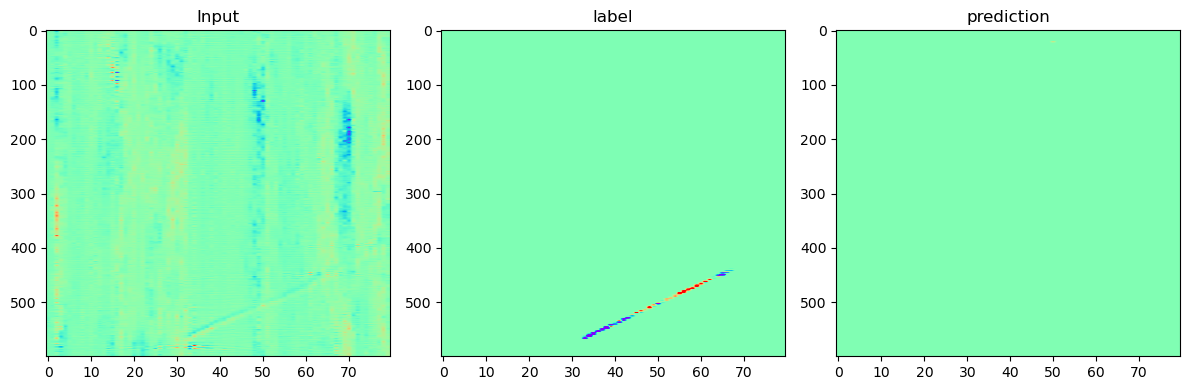

In [32]:
import matplotlib.pyplot as plt

i = 0
scale = 10.
yyy = model(X_test[i:i+1])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
ax1.imshow(X_test[i], aspect = 'auto', cmap='rainbow', vmin=-scale, vmax=scale)
ax1.set_title('Input')
ax2.imshow(y_test[i], aspect = 'auto', cmap='rainbow', vmin=-scale, vmax=scale)
ax2.set_title('label')
ax3.imshow(yyy[0], aspect = 'auto', cmap='rainbow', vmin=-scale, vmax=scale)
ax3.set_title('prediction')
fig.tight_layout()

In [30]:
yyy[0].numpy().max()

5.0340357